In [ ]:
# -*- coding: utf-8 -*-
#  File: otus_pro_hw3.ipynb
#  Project: 'OTUS PRO Homework #3'
#  Created by Gennady Matveev (gm@og.ly) on 14-01-2022.

![OTUS.ML.Pro](https://docs.google.com/uc?export=download&id=1WNdJ3EbDWli0UARUhWLwGmC5_RUuIJ7n)
<!-- https://drive.google.com/file/d/1WNdJ3EbDWli0UARUhWLwGmC5_RUuIJ7n/view?usp=sharing -->

# **$Homework$** **$3$**  
**OTUS Machine Learning Professional**

Goals:   
- Apply **anomaly detection** methods to "Credit Card Fraud Detection" dataset
- Carry out basic EDA
- Use anomaly percentage, calculated by "Class" variable, as an "expert estimate" of the dataset "impurity"
- Estimate the quality of models with their predictions and "Class" variable, using classificationrt and confusion matrix
- Check if anomalies are separated from the rest of data with UMAP/t-sne.

Additional goals:  
- Try outlier detection methods from ATOM library
- Look into PyOD possibilities
- Apply voting classifier

Means:  
- All meaningful programming will be done in sklearn and ATOM
https://tvdboom.github.io/ATOM/about/

Dataset:
- Credit Card Fraud Detection 
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

Abbreviations:
- EDA: exploratory data analysis
- PP: preprocessing
- H/Ps: hyperparameters

<a href="https://colab.research.google.com/github/oort77/OTUS_PRO_HW3/blob/main/notebooks/otus_pro_hw3_atom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

### Google colab specific part

Please uncomment and run the cell below to install dependencies.  
Typical runtime on colab is around 8 minutes (to include installation of libraries ~ 2-3 minutes).

In [ ]:
# !pip install -r "https://drive.google.com/uc?export=download&id=14TOXCFVR7VPnfNiKimcz-BUUaJastb4h"

### Import libraries and setup notebook

In [ ]:
import pandas as pd
# import terality as te
import numpy as np
from atom import ATOMClassifier
from atom.data_cleaning import Pruner

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, \
    MinMaxScaler, RobustScaler,FunctionTransformer, KBinsDiscretizer
from sklearn.compose import make_column_transformer #ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
# from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_samples, silhouette_score
# from sklearn.manifold import TSNE
from umap import UMAP
from scipy.spatial.distance import pdist
# import pandas_profiling

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# from tqdm import tqdm
# from time import sleep
import random
# import re
from IPython.core.display import display, HTML
import warnings


#### Miscellaneius settings 

In [ ]:
%matplotlib inline
display(HTML("<style>.container {width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"]=(12,4)
sns.set(rc={'figure.figsize': (12, 4)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

#### ML parameters

In [ ]:
random_state = 17
random.seed(random_state)
njobs = -1
methods =["z-score","iForest","EE","LOF","SVM","OPTICS"] 

### Load data

In [ ]:
!mkdir ../data
url = "https://drive.google.com/uc?id=1Na6k8qB2aIoHQJeXAnCQXG6gDb6W6MtS"
data = pd.read_csv(gdown.download(
    url, output="../data/archive.zip", quiet=True), compression="zip")

#data = pd.read_csv("../data/archive.zip", compression = "zip")

#Through away "Time" column and convert data to float32
data = data.astype("float32").iloc[:,1:]
data.reset_index(drop=True, inplace=True)
# data.rename(columns={"index":"ID"},inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.62,0.0
1,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.69,0.0
2,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.66,0.0
3,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.50,0.0
4,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.99,0.0


In [ ]:
# Experimental -- drop nearly all but correlated (with "Class") columns
data = data.loc[:,['V2', 'V3', 'V10', 'V12', 'V14', 'V16', 'V17', 'Amount', 'Class']]
data.head()

,V2,V3,V10,V12,V14,V16,V17,Amount,Class
0,-0.0728,2.5363,0.0908,-0.6178,-0.3112,-0.4704,0.2080,149.62,0.0
1,0.2662,0.1665,-0.1670,1.0652,-0.1438,0.4639,-0.1148,2.69,0.0
2,-1.3402,1.7732,0.2076,0.0661,-0.1659,-2.8901,1.1100,378.66,0.0
3,-0.1852,1.7930,-0.0550,0.1782,-0.2879,-1.0596,-0.6841,123.50,0.0
4,0.8777,1.5487,0.7531,0.5382,-1.1197,-0.4514,-0.2370,69.99,0.0


#### Choose full or partial dataset

In [ ]:
partial = 0
rand_part = 0.1 # for computationally expensive parts
# Randomly select rand_part of rows
part = sorted(random.choices(range(data.shape[0]), k=int(data.shape[0]*rand_part)))
if partial == 0:
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
else:
    X, y = data.iloc[part,:-1], data.iloc[part,-1]
X.shape, y.shape

((284807, 8), (284807,))

### Composition of classes

In [ ]:
print(f"Composition of classes:\n-----------------------\n{y.value_counts()}\n\n")
print(f"Percentages:\n------------\n{y.value_counts(normalize=True)}")

Composition of classes:
-----------------------
0.0    284315
1.0       492
Name: Class, dtype: int64


Percentages:
------------
0.0    0.9983
1.0    0.0017
Name: Class, dtype: float64


<div class="alert alert-block alert-success">
<b>"Class"</b> column contains 492 fraud values, only 0.17% of the whole dataset. We will use this number as an "expert estimate".
</div>

### EDA

pass

### Preprocessing

####  Create an ATOM classifier instance

In [ ]:
atom = ATOMClassifier(X, y, n_jobs=njobs, test_size=0.25,
                      verbose=1, warnings=False, random_state=random_state)

<< ================== ATOM ================== >>
Algorithm task: binary classification.
Parallel processing with 8 cores.

Dataset stats ==================== >>
Shape: (284807, 9)
Scaled: False
Outlier values: 19113 (1.0%)
Duplicate samples: 9144 (3.2%)
-------------------------------------
Train set size: 213606
Test set size: 71201
-------------------------------------



####  Check if it's worth to log numerical features

In [ ]:
# atom.distribution("Amount")

In [ ]:
# atom.plot_qq("Amount", distribution="lognorm")

In [ ]:
# atom.plot_distribution("Amount", distribution="lognorm", title = "Distribution of the 'Amount' feature", bins=100)

Define transfoms that may prove to be useful (or not)

In [ ]:
def log_transform(x):
    return np.log1p(x + 1)

log_cols = ["Amount"]#, "Credit amount", "Duration"]
log_transformer = FunctionTransformer(log_transform)
kb = KBinsDiscretizer(n_bins=10, encode="onehot", strategy="quantile")

#### PP sequence

Choice of preprocessing steps strongly affects clustering results. Feel free to play.

In [ ]:
def log_transform(x):
    return np.log1p(x)

log_cols = ["Amount"] #"Age", "Duration"
log_transformer = FunctionTransformer(log_transform)
log1pt = make_column_transformer((log_transformer, log_cols), #["Credit amount"]
                          remainder='passthrough')

In [ ]:
# atom.impute(strat_cat="unknown")
atom.clean(drop_duplicates=True)
# atom.encode()  # frac_to_other=0.05)
atom.add(log1pt)
# atom.add(kb, columns = log_cols)
atom.add(StandardScaler())
# atom.add(RobustScaler())
# atom.add(MinMaxScaler())

# cols=list(atom.X_train.columns)
# cols.remove("ID")
# rscaler = ColumnTransformer(
#         [("rs", RobustScaler(), cols)],
#         remainder="passthrough")
# atom.add(rscaler, columns=cols)

atom.gauss()
# atom.add(kb, columns = log_cols)

Applying data cleaning...
Fitting ColumnTransformer...
Applying ColumnTransformer to the dataset...
Fitting StandardScaler...
Applying StandardScaler to the dataset...
Making features Gaussian-like...


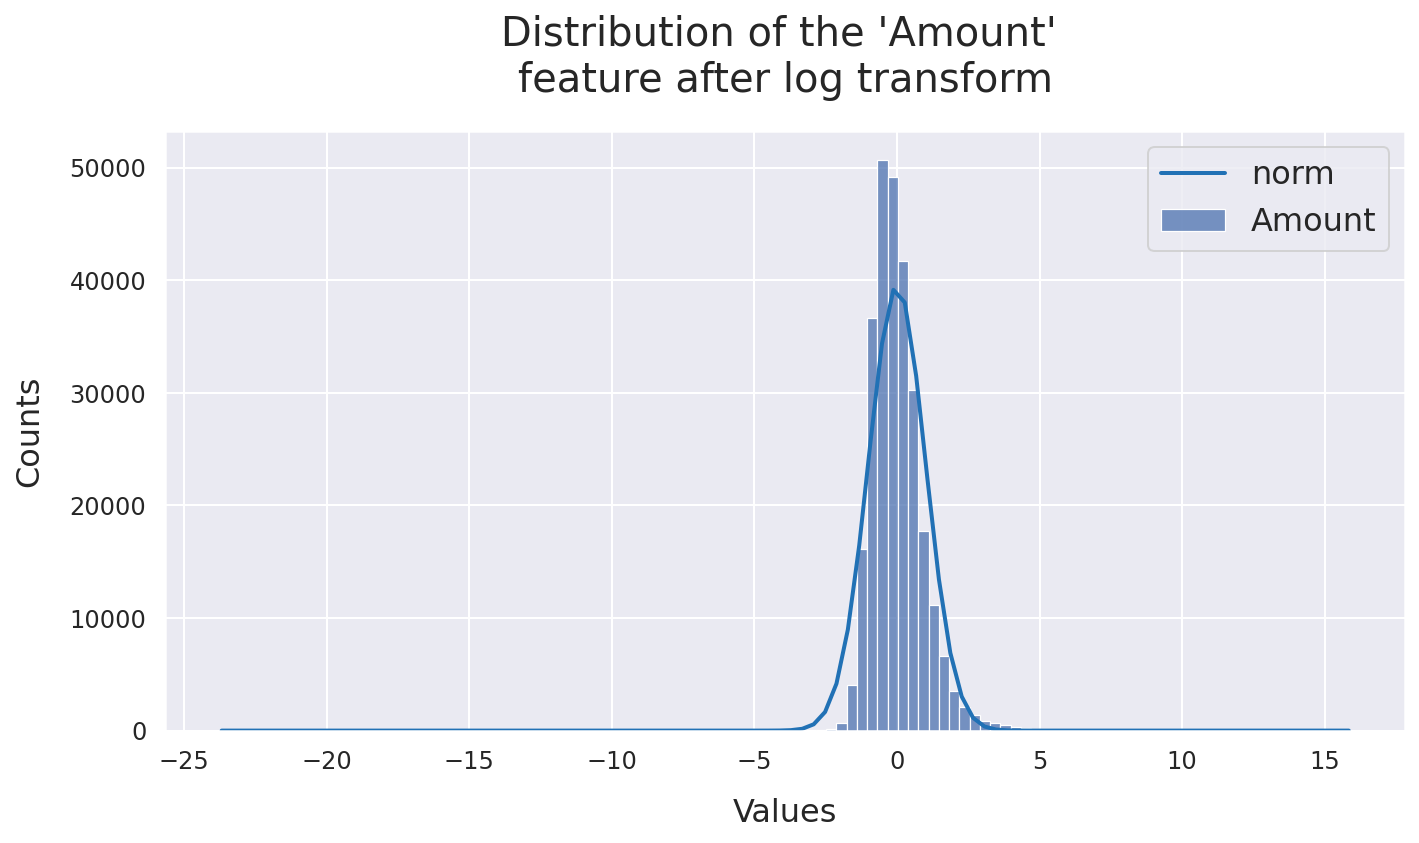

In [ ]:
atom.plot_distribution("Amount", distribution="norm", title = "Distribution of the 'Amount' \nfeature after log transform", bins=100)

In [ ]:
atom.X_train.shape[0]

213606

In [ ]:
atom.X_train.head()
# atom.X_train.shape

# cols

,V2,V3,V10,V12,V14,V16,V17,Amount
0,-1.5596,0.0629,-0.8342,-0.3506,-1.3243,1.8937,-0.3974,0.1093
1,1.5299,-1.1152,0.3694,0.5189,0.1804,-0.6253,1.9325,-0.1198
2,-1.0339,-0.1133,-1.0704,0.0627,-0.2140,0.5860,-0.2450,-0.6420
3,0.3254,-0.4710,0.2028,-0.1723,-1.0814,0.6505,-1.9177,0.3256
4,-1.4457,-0.2008,0.1779,0.0426,-0.1621,0.6233,0.8955,-0.7913


#### Transformed dataset

In [ ]:
atom.X_train.sort_index()[:100].iplot()

#### Distribution of distances in transformed dataset

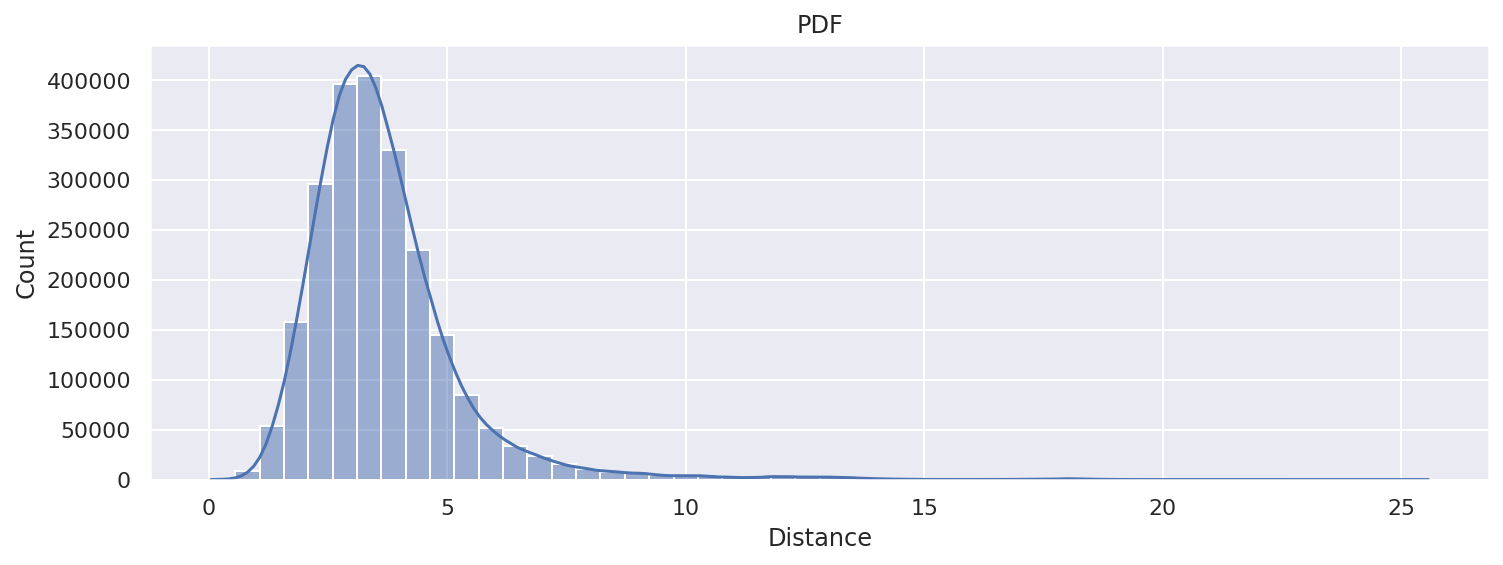

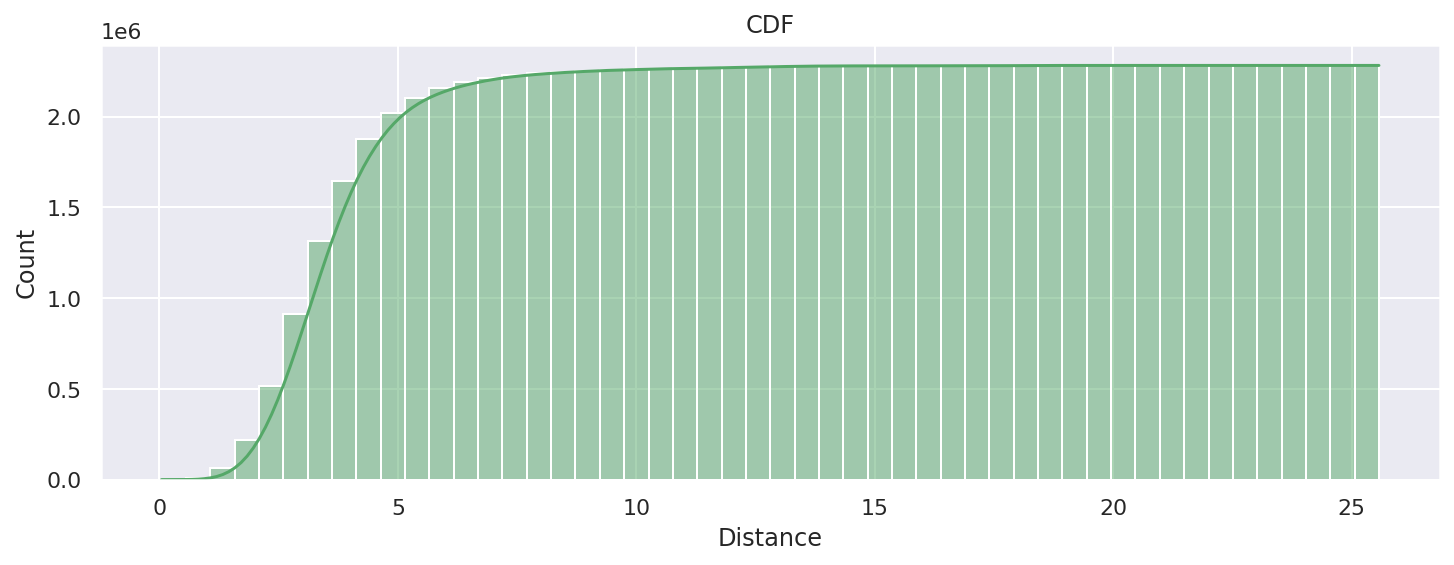

In [ ]:
distr = pdist(atom.X_train[::100].values)
fig, ax = plt.subplots()
plt.setp(ax, xlabel="Distance")
plt.setp(ax, title="PDF")
_ = sns.histplot(data=distr, bins=50, kde=True)

fig, ax = plt.subplots()
plt.setp(ax, xlabel="Distance")
plt.setp(ax, title="CDF")
_ = sns.histplot(data=distr, bins=50, kde=True, cumulative=True, color="g")

### ATOM prune

```
ATOM prune methods:  
"z-score": Uses the z-score of each data value.  
"iForest": Uses an Isolation Forest.  
"EE": Uses an Elliptic Envelope.  
"LOF": Uses a Local Outlier Factor.  
"SVM": Uses a One-class SVM.  
"DBSCAN": Uses DBSCAN clustering.  
"OPTICS": Uses OPTICS clustering.
```

In [ ]:
# pruner=Pruner(strategy="z-score")#,index="ID")
# data = atom.X_train
# data_pr = pruner.transform(data)
# print(data_pr.shape)
# # merged = data_pr.merge(data, left_index=True, right_index=True,
# #                        indicator=True, how='outer').loc[lambda x : x['_merge']=='right_only']
# diff=pd.concat([data_pr,data]).drop_duplicates(keep=False)
# diff.shape
# # outliers = merged[merged.loc[:,"_merge"]=="right_only"].index#[["ID"]]#,"_merge"]]
# # merged.shape
# # atom.X_train.loc[outliers].shape
# # outliers
# diff.head()

In [ ]:
atom.X_train.shape[0]

213606

In [ ]:
print(f"Composition of classes:\n-----------------------\n{atom.y_train.value_counts()}\n\n")
print(f"Percentages:\n------------\n{atom.y_train.value_counts(normalize=True)}")

Composition of classes:
-----------------------
0    213235
1       371
Name: Class, dtype: int64


Percentages:
------------
0    0.9983
1    0.0017
Name: Class, dtype: float64


### Quality check function

In [ ]:
crs = []
def quality_check(y_true, yhat, name):
    print("Confusion matrix:\n")
    cm = confusion_matrix(y_true, yhat)#, normalize="all")
    print(cm)
    disp = ConfusionMatrixDisplay(cm)#.from_predictions
    disp.plot()
    plt.show()
    print("\n-----------------------------------------------------")
    print("\nClassification report:\n")
    cr = classification_report(y_true, yhat)
    print(cr)
    crs.append({name: cr})

### Outliers search

In [ ]:
def find_outliers(data, method, **p):
#     data_copy = data.copy()
    pruner=Pruner(strategy=method, **p)
    data_pr = pruner.transform(data)#(data_copy)
#     print(f"{method}: {data_pr.shape[0]}")
#     merged = data_pr.merge(data_copy, left_index=True, right_index=True,
#                        indicator=True, how='outer',sort=True).loc[lambda x : x['_merge']!='both']
#     outliers = merged[merged.loc[:,"_merge"]=="right_only"].index
    outliers=pd.concat([data_pr, data]).drop_duplicates(keep=False).index #data_copy
#     print(outliers.shape[0])
#     return data.loc[outliers]
#     result_X = data.iloc[outliers] #data_copy
    result_y = pd.DataFrame(np.zeros(data.shape[0])) #data_copy
    result_y.iloc[outliers] = 1 
    return result_y

# for m in methods:
#     print(f"{m:>8}: {find_outliers(atom.X_train, m).shape[0]:5d} outliers")

2160 outliers

Confusion matrix:

[[211081   2154]
 [   365      6]]


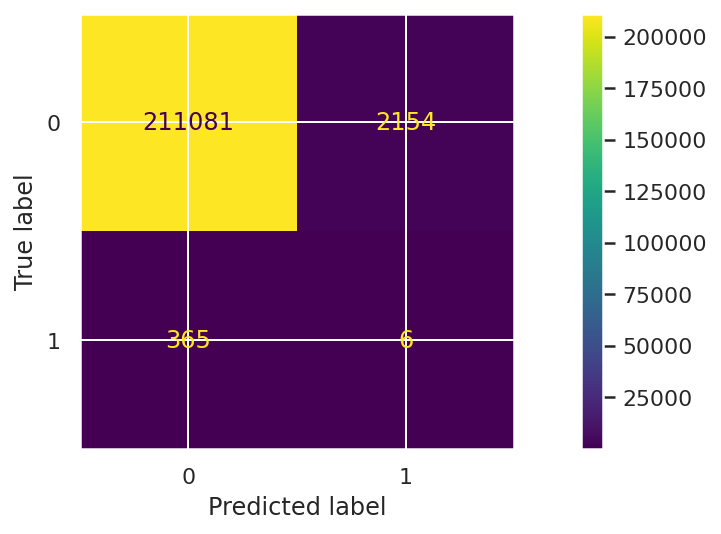


-----------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    213235
           1       0.00      0.02      0.00       371

    accuracy                           0.99    213606
   macro avg       0.50      0.50      0.50    213606
weighted avg       1.00      0.99      0.99    213606



In [ ]:
zscore = find_outliers(atom.X_train, "z-score", max_sigma=5)#.shape[0]
print(f'{zscore.value_counts()[1]} outliers\n')
quality_check(atom.y_train, zscore, name="zscore")

```
class sklearn.ensemble.IsolationForest(*, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)
```

3631 outliers

Confusion matrix:

[[209611   3624]
 [   364      7]]


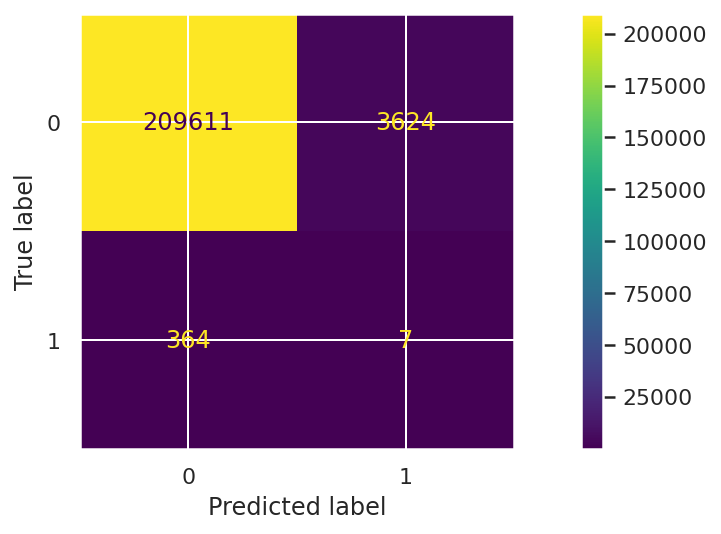


-----------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    213235
           1       0.00      0.02      0.00       371

    accuracy                           0.98    213606
   macro avg       0.50      0.50      0.50    213606
weighted avg       1.00      0.98      0.99    213606



In [ ]:
iforest = find_outliers(atom.X_train, "iForest", n_estimators=100, 
                        contamination=0.0017, max_features=1.0, bootstrap=False, 
                        n_jobs=njobs, random_state=random_state)
print(f'{iforest.value_counts()[1]} outliers\n')
quality_check(atom.y_train, iforest, name="iforest")

```
class sklearn.cluster.OPTICS(*, min_samples=5, max_eps=inf, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, memory=None, n_jobs=None
```

In [ ]:
%%script false --no-raise-error

optics = find_outliers(atom.X_train, "OPTICS", min_samples=5, max_eps=2.0, eps=1.0, xi=0.05,  
                       predecessor_correction=True, min_cluster_size=15, leaf_size=30, 
                       memory="./cache", n_jobs=njobs)#.shape[0] #,
print(f'{optics.value_counts()[1]} outliers')
quality_check(atom.y_train, optics, name="optics")

```
class sklearn.covariance.EllipticEnvelope(*, store_precision=True, assume_centered=False, support_fraction=None, contamination=0.1, random_state=None)
```

3632 outliers
Confusion matrix:

[[209610   3625]
 [   364      7]]


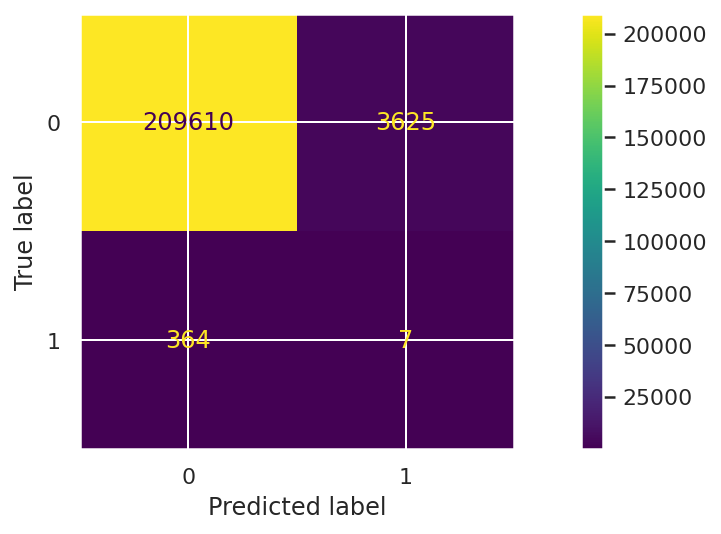


-----------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    213235
           1       0.00      0.02      0.00       371

    accuracy                           0.98    213606
   macro avg       0.50      0.50      0.50    213606
weighted avg       1.00      0.98      0.99    213606



In [ ]:
ee = find_outliers(atom.X_train, "EE", contamination=0.017, random_state=random_state)
print(f'{ee.value_counts()[1]} outliers')
quality_check(atom.y_train, ee, name="ee")

```
class sklearn.neighbors.LocalOutlierFactor(n_neighbors=20, *, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination='auto', novelty=False, n_jobs=None)
```

3632 outliers
Confusion matrix:

[[209608   3627]
 [   366      5]]


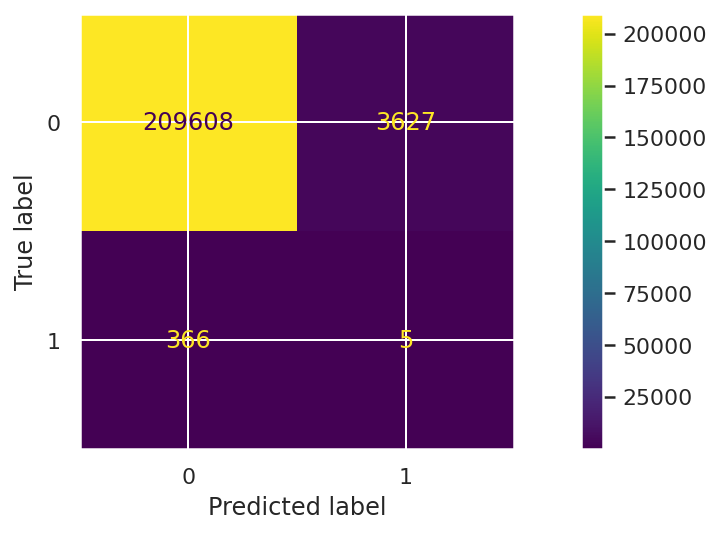


-----------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    213235
           1       0.00      0.01      0.00       371

    accuracy                           0.98    213606
   macro avg       0.50      0.50      0.50    213606
weighted avg       1.00      0.98      0.99    213606



In [ ]:
lof = find_outliers(atom.X_train, "LOF", contamination=0.017, n_jobs=njobs)
print(f'{lof.value_counts()[1]} outliers')
quality_check(atom.y_train, lof, name="lof")

```
class sklearn.svm.OneClassSVM(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)
```

3635 outliers
Confusion matrix:

[[209606   3629]
 [   365      6]]


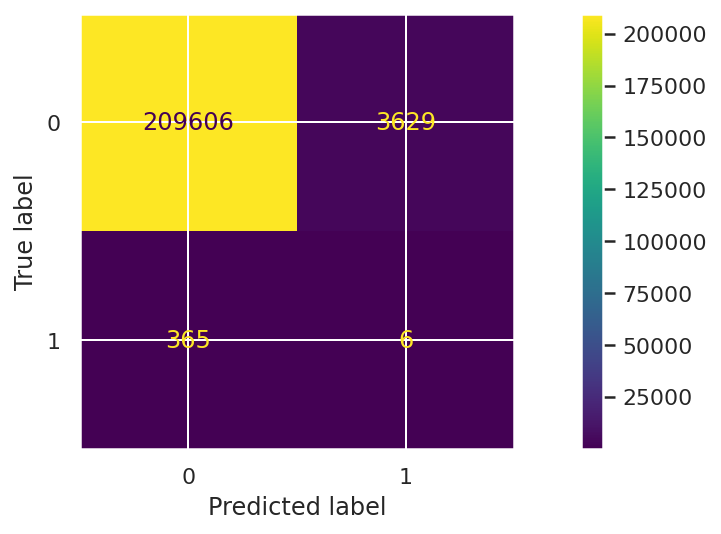


-----------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    213235
           1       0.00      0.02      0.00       371

    accuracy                           0.98    213606
   macro avg       0.50      0.50      0.50    213606
weighted avg       1.00      0.98      0.99    213606



In [ ]:
svm = find_outliers(atom.X_train,"SVM", nu=0.017)
print(f'{svm.value_counts()[1]} outliers')
quality_check(atom.y_train, svm, name="svm")

It seems that all reports are misleading: ATOM reindexes data after application of estimators, including *pruner*. As a result, the count of detected outliers is wrong.